# Get reading from image using OpenCV-Python
Wrote by Lei Lei</br>
Faculty of Engineering, University of Nottingham

Input image directory, make output directory, load image.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'

Define a crop function. Reshape and crop the image to save computation efforts.

In [ ]:
def rescaleFrame(frame, scale = 0.3):
    width = int(frame.shape[1]*scale)
    height = int(frame.shape[0]*scale)
    dimensions = (width, height)  
    return cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)

In [ ]:
# Reading Video
capture=cv2.VideoCapture('/mnt/c/users/stcik/scire/papers/muon/84C.MOV')
count = 0
success = True
fps = int(capture.get(cv2.CAP_PROP_FPS))
out_folder='/mnt/c/users/stcik/scire/papers/muon/84C/frames'
os.makedirs(out_folder,exist_ok=True)
while success:
    success, image = capture.read()
    if count%(1*fps) == 0 :
        image = rescaleFrame(image)
        cv2.imwrite(os.path.join(out_folder,'frame%d.jpg'%count),image)
#         print('Successfully written frame%d!'%count)
    count+=1

In [15]:
def crop(img, params = (200, 400, 160, 300)):
    # Parameters in the order of y, h, x, w
    new_image = img[params[0]:params[1], params[2]:params[3]]
    return new_image

In [3]:
def plot(image, cmap=None):
    plt.axis('off')
    plt.imshow(image)

Batch reshape & crop frames.

In [43]:
rDir = r'./frames'
out_folder='outs'
os.makedirs(out_folder,exist_ok=True)

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir,file))
savs=savs[82:]

for sav in savs:
    image_path=sav
    image=cv2.imread(image_path)
    new_image=crop(image, width=500, y=120, h=440, x=50, w=410)
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join(out_folder, f'100C_{name}'), new_image)

Mannual crop some frames, where camera moved a lot

In [42]:
image_path=r'./frames/frame2320.jpg'
image=cv2.imread(image_path)
new_image = crop(image, width=500, y=120, h=430, x=60, w=370)
name = image_path.split('/')[-1]
cv2.imwrite(os.path.join(out_folder, f'100C_{name}'), new_image)

True

Define functions to detect text box.

In [2]:
def make_bin(img, gmin=190, gmax=255):
    """Make a binary image from the cropped image."""
    # Thresholding the image
    (thresh, img_bin) = cv2.threshold(img, gmin, gmax, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    img_bin = 255-img_bin
    cv2.imwrite("Images/Image_bin.jpg", img_bin)
#     plt.axis('off')
#     plt.imshow(img_bin)
    return img_bin

def get_lines(img, verticle_kernel, hori_kernel):
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("Images/verticle_lines.jpg", verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    cv2.imwrite("Images/horizontal_lines.jpg", horizontal_lines_img)
#     plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
#     plt.imshow(verticle_lines_img);
#     plt.axis('off')

#     plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
#     plt.imshow(horizontal_lines_img);
#     plt.axis('off')
    return verticle_lines_img, horizontal_lines_img

def combine(img1, img2, alpha, beta):
    """Combine the horizontal and vertical lines
    alpha and beta are weighting parameters, this will decide the quantity of an image to be added to make a new image."""
    img_final_bin = cv2.addWeighted(img1, alpha, img2, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 125,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     plt.axis('off')
#     plt.imshow(img_final_bin)
    return img_final_bin

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_reading(img, contours, folder):
#     xpos=[]
    ypos=[]
#     wlist=[]
    hlist=[]
    for c in contours:
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # If a box height is greater then 20 & widht is greater then 20 and 0.8*h > w > 0.40*h, add it's position info in the empty lists.
        if (w > 20 and h > 20) and 0.8*h > w > 0.40*h:
#             xpos.append(x)
            ypos.append(y)
#             wlist.append(w)
            hlist.append(h)
    new_img = img[np.array(ypos).min():np.array(ypos).min()+np.array(hlist).max(), 60:300]
#     print(np.array(ypos).min(),np.array(ypos).max()+np.array(hlist).max(), np.array(xpos).min(),np.array(xpos).max()+np.array(wlist).max())
#     plt.imshow(new_img)
#     plt.axis('off')
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join(folder, f'temp_{name}'), new_img)

Batch process the frames, save the detecte region into ./outs directory.

In [6]:
# Set up the parameters to find horizontal and vertical lines.
alpha = 0.5
beta = 1.0 - alpha
savs=[]
rDir = r'./cropped'
out_folder=r'./outs'

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir,file))
# counts=1
for sav in savs:
    image_path=sav
    image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Defining a kernel length
    kernel_length = np.array(image).shape[1]//150
    # print(kernel_length)
    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_bin=make_bin(image)
    verticle_lines_img, horizontal_lines_img = get_lines(img_bin, verticle_kernel = verticle_kernel, hori_kernel = hori_kernel)
    img_final_bin=combine(verticle_lines_img, horizontal_lines_img, alpha = alpha, beta = beta)
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    get_reading(image, contours = contours, folder = out_folder)

NameError: name 'make_bin' is not defined

Crop mannually for bad contrast frames

frame3799.jpg


True

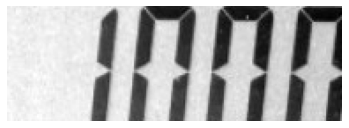

In [85]:
image_path=r'./cropped/100C_frame3799.jpg'
image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
new_image = image[115:180, 70:260]
plt.axis('off')
plt.imshow(new_image)
name = image_path.split('/')[-1]
name = name.split('_')[-1]
out_folder=r'./outs'
print(name)
cv2.imwrite(os.path.join(out_folder, f'temp_100C_{name}'), new_image)

In [5]:
def make_bin(img, gmin=90, gmax=180):
    # Thresholding the image
    (thresh, img_bin) = cv2.threshold(img,gmin, gmax, cv2.THRESH_BINARY)
    # Invert the image
    img_bin = ~img_bin
    return img_bin

In [6]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [119]:
# We will use the size and position of the contourbox to filter the boxes.
def get_reading(img, contours):
    # Get the width and height of the image
    height, width = img.shape
#     print(width, height)
    textcont=[]
    for c in contours:
        # Returns the location and width, height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # We will only use the height of the numbers, because all numbers have about the same height but 1 is much narrower than other numbers.
        # We will only use the y positions, because the x positions has a larger distribution.
        if 0.3 > h/height > 0.08 and (1.8*(height-y-h) > y > 0.35*(height-y-h) and 0.15*width < x < 0.80*width):
            textcont.append(c)
#             print(x, y, w, h, h/height, y/(height-y-h))
    return textcont

In [101]:
line_min_width = 8
kernal_h = np.ones((3,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,3), np.uint8)

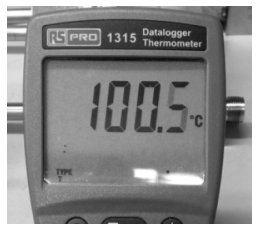

In [110]:
image_path=r'/mnt/c/users/stcik/scire/papers/muon/100C/cropped/100C_frame4495.jpg'
new_image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plot(new_image)

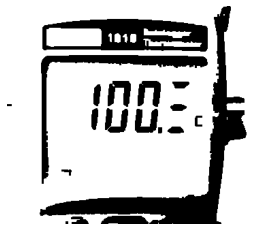

In [106]:
img_bin=make_bin(new_image, gmin=110, gmax=195)
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
img_bin_final=img_bin_h|img_bin_v
final_kernel = np.ones((1,1), np.uint8)
img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
img_bin_final=~img_bin_final
plot(img_bin_final)

In [99]:
#Retrieve contours 
contours, hierarchy = cv2.findContours(img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
textcont = get_reading(new_image, contours)
textbox = []
for c in textcont:
    x, y, w, h = cv2.boundingRect(c)
    textbox.append([x,y,w,h])
print(textbox)

[[187, 148, 36, 39], [147, 148, 32, 39], [143, 148, 13, 36], [123, 148, 12, 36], [126, 113, 13, 36], [190, 109, 37, 41], [147, 109, 36, 40]]


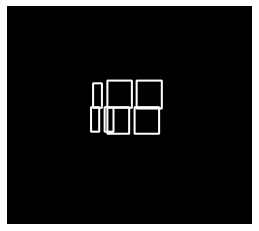

In [100]:
img_box = np.zeros(new_image.shape, dtype = "uint8")
for n in textbox:
    img_box = cv2.rectangle(img_box, (n[0],n[1]), (n[0]+n[2],n[1]+n[3]), (255,0,0), 2)
plot(img_box)

109 187 118 272


True

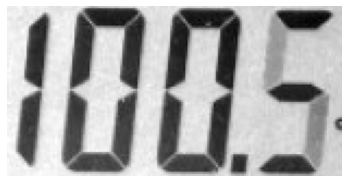

In [111]:
textcont, textboxes = sort_contours(textcont, method="left-to-right")
xpos, xwidth = textboxes[0][0]-5, textboxes[-1][0]+textboxes[-1][2]
textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
ypos, yheight = textboxes[0][1], textboxes[-1][1]+textboxes[-1][3]
print(ypos, yheight, xpos, xwidth)
new_image = new_image[ypos:yheight, xpos:xwidth]
name = image_path.split('/')[-1]
plot(new_image)
cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/100C/newouts/{name}', new_image)

In [133]:
nums = range(5568,5655,29)
for num in nums:
    num = str(num)
    image_path=f'/mnt/c/users/stcik/scire/papers/muon/100C/cropped/100C_frame{num}.jpg'
    image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_bin=make_bin(image, gmin=90, gmax=180)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
    img_bin_final=img_bin_h|img_bin_v
    final_kernel = np.ones((1,1), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
    img_bin_final=~img_bin_final
    #     plot(img_bin_final)
    contours, hierarchy = cv2.findContours(img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    textcont = get_reading(image, contours)
    textcont, textboxes = sort_contours(textcont, method="left-to-right")
    xpos, xwidth = textboxes[0][0]-3, textboxes[-1][0]+textboxes[-1][2]+7
    textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
    ypos, yheight=textboxes[0][1]-3, textboxes[-1][1]+textboxes[-1][3]+4
#     print(ypos, yheight, xpos, xwidth)
    new_image = image[ypos:yheight, xpos:xwidth]
    name = image_path.split('/')[-1]
    #     plot(new_image)
    cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/100C/newouts/{name}', new_image)

In [164]:
def make_bin(img, gmin=90, gmax=180):
    # Thresholding the image
    (thresh, img_bin) = cv2.threshold(img,gmin, gmax, cv2.THRESH_BINARY)
    # Invert the image
    img_bin = ~img_bin
    return img_bin

In [134]:
rDir = r'/mnt/c/users/stcik/scire/papers/muon/100C/newouts'
out_folder='/mnt/c/users/stcik/scire/papers/muon/100C/binary'
os.makedirs(out_folder,exist_ok=True)

for file in os.listdir(rDir):
        image_path=os.path.join(rDir,file)
        image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_bin=make_bin(image)
        name = image_path.split('/')[-1]
        cv2.imwrite(os.path.join(out_folder, f'{name}'), img_bin)

In [137]:
readings=[99.8,100.0,100.3,100.3,100.3,100.2,100.2,100.2,100.4,100.4,100.4,
         100.6,100.8,100.8,101.0,101.1,101.1,101.3,101.3,101.3,101.2,101.1,
         100.9,100.9,100.5,100.5,100.2,100.3,100.3,100.4,100.4,100.4,100.4,
         100.6,100.6,100.4,100.3,100.2,100.1,100.1,100.1,100.2,100.4,100.4,
         100.3,100.2,100.2,100.3,100.3,100.2,99.7,99.7,99.6,99.2,99.2,
         98.7,98.2,98.4,98.4,98.6,98.8,98.8,98.8,98.8,98.8,99.0,
         99.0,99.0,99.0,99.1,99.1,99.2,99.2,99.6,99.8,99.8,99.6,
         99.6,99.6,99.8,100.1,100.2,100.2,100.2,100.5,100.5,100.7,100.7,
         100.7,100.6,100.4,100.1,100.1,100.2,100.2,99.9,99.9,100.4,100.4,
         100.4,100.5,100.5,100.2,100.2,100.3,100.4,100.4,100.5,100.7,100.7,
         100.7,100.8,100.8,100.8,100.8,100.8,100.8,100.9,100.9,101.1,101.1,
         101.0,100.9,100.9,100.9,100.9,100.8,100.8,100.4,100.0,100.0,99.8,
         99.9,99.9,100.0,100.2,100.2,100.2,100.2,100.2,100.2,101.1,100.1,
         99.9,99.4,99.4,99.4,99.3,99.3,99.4,99.4,99.4,99.8,100.2,
         100.3,100.5,100.6,100.6,100.6,100.8,100.8,100.8,100.5,100.7,100.7,
         100.8,100.8,100.8,101.0,101.0,100.9,100.9,101.3,101.2,100.6,100.6,
         100.6,100.7,100.9,100.9,100.8,100.9,100.9,100.8,100.8,100.9,100.9,
         101.1,101.1,101.3,101.3,101.4,101.4,101.4]
print(len(readings))

194


In [145]:
# 80 C as validation data
readings=[81.6,81.6,81.6,81.6,81.6,81.6,81.9,81.9,81.3,81.3,81.3,
         81.3,81.4,81.6,81.6,81.8,82.0,82.0,81.9,81.9,81.3,81.3,
         81.3,81.2,81.2,81.2,81.0,81.3,81.3,81.4,81.5,81.5,81.5,
         81.8,81.5,81.5,81.5,81.3,81.3,81.2,81.0,81.0,81.1,81.1,
         80.9,80.7,80.7,80.7,80.7,80.7,81.0,81.0,81.2,81.2,81.1,
         81.3,81.3,81.6,81.9,81.9,82.0,82.0,82.0,82.1,82.8,81.8,
         81.9,81.9,81.9,81.8,81.8,81.8,81.7,81.7,81.7,81.3,80.9,
         80.9,80.8,80.4,80.4,80.4,80.0,80.0,80.1,80.2,80.1,80.1,
         80.4,80.4,80.2,80.2,80.3,80.4,80.6,80.6,80.7,80.8,80.8,
         80.8,80.9,80.9,81.0,81.1,81.1,80.9,81.1,81.0,81.0,80.9,
         80.6,80.6,80.8,80.8,80.9,80.9,80.9,81.0,81.2,81.2,81.3,
         81.5,81.5,81.7,81.9,81.9,82.0,82.0,82.2,82.2,82.1,82.1,
         82.1,82.1,81.9,81.9,81.8,81.8,81.9,81.8,81.8,82.1,81.4,
         81.4,81.6,80.9,80.3,80.3,79.8,79.7,79.7,79.6,80.1,80.1,
         80.7,81.1,81.1,81.4,81.9,81.9,82.2,82.2,82.3,81.8,81.8,
         81.7,81.0,81.4,80.4,80.4,80.7,80.7,81.5,82.0,82.0,81.9,
         81.9,81.9,81.8,81.8,81.9,81.9,82.3,82.3,82.3,82.3,82.3,
         82.8,82.7,82.7,82.5,82.6,82.6,82.6,82.4,82.4,82.3,82.2,
         82.2,82.3,82.3,82.3,82.3,81.7,81.4,81.4,81.2,81.9,81.9,
         82.0,82.0,82.3,82.7,82.7,82.8,82.9,82.9,83.1,83.2,83.2,
         83.0,82.6,82.5,82.3,81.5,81.1,81.1,80.6,80.1,80.1,79.2,
         78.8,78.8,79.1,79.1,79.3,79.6,79.6,79.8,79.8,79.8,79.1,
         78.4,78.3,78.3,77.7,77.9,77.9,77.4,77.1,82.3]
print(len(readings))

251


In [3]:
# Other data
# Add 8 C readings as training data
readings=[83.8,83.8,83.6,83.6,83.8,83.8,83.8,83.8,83.9,83.6,83.6,
         83.6,83.5,83.5,83.2,83.2,82.9,82.9,82.9,82.8,82.9,82.9,
         83.0,83.0,83.0,83.1,83.1,83.1,83.1,83.1,83.2,83.2,83.3,
         83.4,83.4,83.6,83.7,83.7,83.8,83.8,83.8,83.8,83.8,84.0,
         83.9,83.9,83.9,83.9,83.9,84.0,84.1,84.2,84.2,84.3,84.4,
         84.4,84.6,84.6,84.6,84.6,84.5,84.5,84.4,84.4,84.4,84.3,
         84.3,84.2,84.1,83.9,83.8,83.3,82.9,82.9,82.6,82.4,82.4,
         82.4,82.4,82.4,82.6,83.0,83.0,83.2,83.4,83.6,83.6,83.6,
         83.6,83.7,83.8,83.8,83.8,83.7,83.7,83.7,83.8,83.8,84.1,
         84.2,84.2,84.3,84.4,84.4,84.3,84.3,84.2,84.2,84.2,83.8,
         83.8,83.8,83.6,83.3,83.4,83.4,83.3,83.1,83.1,83.1,83.1,
         83.1,83.2,83.1,83.3,83.3,83.3,83.3,83.3,83.4,83.4,83.4,
         83.4,83.6,83.6,83.6,83.6,83.9,83.9,83.9,84.1,84.2,84.2,
         84.3,84.3,84.4,84.4,84.4,84.5,84.5,84.5,84.6,84.6,84.6,
         84.6,84.6,84.5,84.5,84.5,84.5,84.5,84.4,84.3,84.3,84.3,
         84.3,84.5,84.5,84.4,84.4,84.4,84.4,84.4,84.4,84.5,84.5,
         84.5,84.5,84.5,84.6,84.6,84.7,84.7,84.8,84.8,84.7,84.8,
         84.7,84.7,84.7,84.6,84.6,84.4,84.2,84.2,84.0,83.7,83.7,
         83.7,83.6,83.6,83.6,83.6,83.8,83.8,83.7,83.7,83.4,83.4,
         83.4,83.4,83.4,83.4,83.4,83.3,83.3,83.3,83.7,83.7,83.7,
         83.8,83.8,83.8,83.7,83.9,83.9,84.1,84.3,84.3,84.4,84.4,
         84.4,84.7,84.7,84.5,84.6,84.6,84.8,84.9,84.9,85.1,85.1,
         85.0,85.0,85.1,85.0,85.0,84.8,84.7,84.7,84.7,84.8,84.8,
         84.7,84.7,84.7,84.7,84.7,84.7,84.8,84.8,84.7,84.7,84.6,
         84.6]
print(len(readings))

265


In [146]:
rDir = r'/mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark/validation/test'
savs=[]

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir,file))

data = [savs, readings]

with open('/mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark/validation/gt.txt', 'w') as f:
    for x in zip(*data):
        f.write("{0}\t{1}\n".format(*x))
print('Data saved!')
f.close()

Data saved!


Make train dataset from the readings and pictures

In [147]:
# Change directory to the deep-text-recognition-benchmark package folder
%cd /mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark/

/mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark
/mnt/c/users/stcik/scire/papers/muon/deep-text-recognition-benchmark


In [148]:
# Use the creat_lmdb_dataset.py script to creat train dataset.
!python3 create_lmdb_dataset.py --inputPath data/ --gtFile data/gt.txt --outputPath result/train/

Created dataset with 605 samples


Make validation dataset from the readings and pictures

In [149]:
!python3 create_lmdb_dataset.py --inputPath validation/ --gtFile validation/gt.txt --outputPath result/test/

Created dataset with 251 samples


In [ ]:
# Code to prevent colab from sign out without saving models:
from pynput.mouse import Button, Controller
import time

mouse = Controller()

while True:
    mouse.click(Button.left, 1)
    time.sleep(30)

In [151]:
!pip3 install pynput

     |████████████████████████████████| 99 kB 311 kB/s eta 0:00:01
     |████████████████████████████████| 178 kB 483 kB/s eta 0:00:01
  Created wheel for evdev: filename=evdev-1.4.0-cp38-cp38-linux_x86_64.whl size=99606 sha256=9cf9943580efad97d0afb6e8a4ff4eef580729cb4309288628fb3e534cb6db55
  Stored in directory: /home/kudoshiji/.cache/pip/wheels/2f/0e/b1/b53ce200baf12820c90fab66f6e0bc9ef4f55285305cc4b687
Successfully built evdev
